In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import vegas
from constants import *
from supernovaNuBoostedDM import *
from bdmLegacy import *
import ipyparallel as ipp
from functools import partial

In this example, we import physical constants from `constants.py` and five functions from `supernovaNuBoostedDM.py` for evaluating BDM flux at Earth and the associated event rate in the detector. The five functions are `diffCrossSectionNuDM`, `totalCrossSectionDMe`, `get_tvan_thetaM`, `diffFluxAtEarth` and `diffEventRateAtDetector`. The first two are for differential $\chi\nu$ and total $\chi e$ scattering cross sections. They are simply for illustrative purpose. The most important are the last three functions and are for calculating BDM flux and the event rate in the detector. There are many auxillary functions in the `supernovaNuBoostedDM.py`, but might not directly relate to this example.

### Instructions

1. `diffCrossSectionNuDM(Tx,mx,mV,psi,gV,gD)`: This calculates the differential $\chi\nu$ cross section $d\sigma_{\chi\nu}/d\psi$ and the unit is [cm$^2$ rad$^{-1}$]. The inputs are
    - `Tx`: The BDM kinetic energy in MeV
    - `mx`: The DM mass in MeV
    - `mV`: The mediator mass in MeV
    - `psi`: BDM scattering angle in lab-frame in rad
    - `gV` and `gD`: DM-$\nu$ and DM-DM coupling constants, they are dimensionless, so just numbers. To realize the perturbative condition, both should be smaller than $\mathcal{O}(1)$
2. `totalCrossSectionDMe(Tx,mx,mV,eps,gD)`: This calculates the total $\chi e$ cross section $\sigma_{\chi e}$ and the unit is [cm$^2$]. Inputs are indentical to the last function but with the new term
    - `eps`: DM-$e$ coupling constant

In [5]:
# Calculate diff. DM-nu cross section
mx_ls = [1e-6,1e-4,1e-2,1,100]
psi_ls = np.logspace(-5,np.log10(0.5*np.pi),100)
Tx = 15
DMnu_crox_mx = []
for mx in mx_ls:
    DMnu_crox_psi = []
    for psi in psi_ls:
        mV = mx/3
        diff_crox = diffCrossSectionNuDM(Tx,mx,mV,psi,1,1)
        DMnu_crox_psi.append(diff_crox)
    DMnu_crox_mx.append(DMnu_crox_psi)

Text(0.5, 1.0, '$T_\\chi = 15$ MeV and $g_V=g_D=1$')

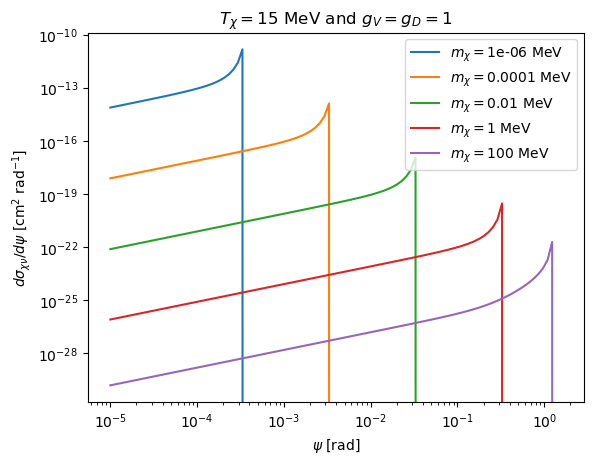

In [6]:
for i in range(len(mx_ls)):
    plt.plot(psi_ls,DMnu_crox_mx[i],label = r'$m_\chi=$' + str(mx_ls[i]) + ' MeV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\psi$ [rad]')
plt.ylabel(r'$d\sigma_{\chi\nu}/d\psi$ [cm$^2$ rad$^{-1}$]')
plt.legend()
plt.title(r'$T_\chi = 15$ MeV and $g_V=g_D=1$')

In [7]:
# Calculate DM-e cross section
mx_ls = np.logspace(-6,1,100)
Tx_ls = [5,30,75,100]
DMe_crox_Tx = []
for Tx in Tx_ls:
    DMe_crox_mx = []
    for mx in mx_ls:
        mV = mx/3
        diff_crox = totalCrossSectionDMe(Tx,mx,mV,1,1)
        DMe_crox_mx.append(diff_crox)
    DMe_crox_Tx.append(DMe_crox_mx)

Text(0.5, 1.0, '$g_D=\\epsilon=1$')

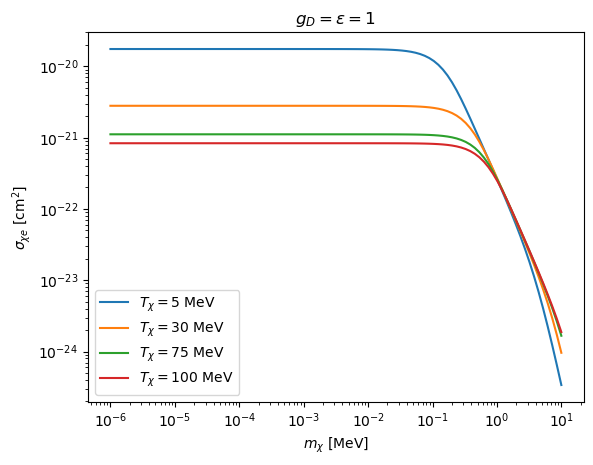

In [8]:
for i in range(len(Tx_ls)):
    plt.plot(mx_ls,DMe_crox_Tx[i],label = r'$T_\chi=$' + str(Tx_ls[i]) + ' MeV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$\sigma_{\chi e}$ [cm$^2$]')
plt.legend()
plt.title(r'$g_D=\epsilon=1$')

3. `diffFluxAtEarth(t,Tx,mx,mV,Rstar,theta,phi,beta,Re=8.5,r_cut=1e-5,gV=1,gD=1,tau=10)`: The differential BDM flux at Earth and the unit is [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]. The inputs are
    - `t`: The time in second
    - `Rstar`: The distance from SN to Earth, in kpc
    - `theta`: The open-angle along the line-of-sight of SN-Earth direction, in rad
    - `phi`: The azimuthal angle along the line-of-sight of SN-Earth direction, in rad
    - `beta`: The off-center angle, in rad. When beta = 0, it implies SN is at any position on the GC-Earth direction
    - `Re`: The distance between GC and Earth, in kpc, default 8.5
    - `r_cut`: Below which distance we should ignore the DM number density, in kpc, default 1e-5
    - `tau`: The duration of SN explosion, in second, default 10
<p>This function simply implies that
    $$
    \texttt{diffFluxAtEarth} = \frac{d\Phi_\chi(t)}{dtdT_\chi d\theta}.
    $$
    To get the flux at a specific time $t_s$, we do the following integration
    $$
    \frac{d\Phi_\chi (t_s)}{dt} = \int_0^{\theta_M} d\theta \int_{5\,{\rm MeV}}^{100\,{\rm MeV}} dT_\chi \frac{d\Phi_\chi(t_s)}{dtdT_\chi d\theta}
    $$
    where $\theta_M$ is the maximum open-angle that results in non-zero $d\Phi_\chi(t)/dtdT_\chi d\theta$. In principle one can set $\theta_M = \pi/2$. However, if $\theta_M$ can be determined in advance, it greatly reduces the difficulty of evaluating such integral. If $\theta_M$ is very small, eg. $10^{-5}$ and we take the upper bound as $\pi/2$, vegas might output 0 due to the Markov Chain is unable to reach the region of non-zero result.

4. `diffEventRateAtDetector(t,Tx,mx,mV,Rstar,theta,phi,beta,Re=8.5,r_cut=1e-5,gV=1,gD=1,eps=1,tau=10)`: The differential BDM event rate in the detector. The unit is [MeV$^{-1}$ s$^{-1}$ sr$^{-1}$ #$_e^{-1}$] and #$_e^{-1}$ means per electron. To get the correct differential event rate of a detector, one should multiply the associate total electron number $N_e$ of that detector. The inputs are
    - `eps`: DM-$e$ coupling constant, dimensionless, default 1
5. `thetaBound(t,Tx,mx,Rstar)`: Get the range of open angle theta for a given set of parameters.

6. `get_tvan_thetaM(Tx,mx,Rstar)`: Get the maximu open-angle $\theta_M$ that is required in the integration of differential BDM flux at Earth. This function outputs ($t_{\rm van}$,$\theta_M$). $t_{\rm van}$ indicates the vanishing time of the BDM flux in seconds and $\theta_M$ is the upper bound for the integration in rad. Note that $\theta_M$ corresponds to $t=0$.
    
#### Legacy function

7. `diffFluxAtEarthLegacy(t,Tx,mx,Rstar,theta,phi,beta,sigxv=1e-45,Re=8.5,r_cut=1e-5,tau=10)`: Legacy function that is exactly the same as `diffFluxAtEarth` but in terms of model-agnostic perspective. Thus the cross section $\sigma_{\chi\nu}$ is manual input and independent of coupling constants $g_V,g_D$ and mediator mass $m_V$.

In [44]:
# BDM kinematics
Tx = 15
mx = 1e-3
mV = mx
# Rstar
Rstar1 = 8.5
Rstar2 = 17
Rstar3 = 17
# Off-center angle
beta1 = 0
beta2 = 0
beta3 = 0.5*np.pi
# Get the vanishing time and maximum theta_M
tvan1,thetaM1 = get_tvan_thetaM(Tx,mx,Rstar1)
tvan2,thetaM2 = get_tvan_thetaM(Tx,mx,Rstar2)
tvan3,thetaM3 = get_tvan_thetaM(Tx,mx,Rstar3)
time_ls1 = np.logspace(np.log10(5),np.log10(tvan1),200)
time_ls2 = np.logspace(np.log10(5),np.log10(tvan2),200)
time_ls3 = np.logspace(np.log10(5),np.log10(tvan3),200)

# setup function for ipyparallel
# the function is completely independent of this notebook
# everything required should be imported again within function body
def fluxToF(t,Tx,mx,mV,thetaM,Rstar,beta):
    # import necessary package
    import vegas
    import numpy as np
    from supernovaNuBoostedDM import diffFluxAtEarth
    # body
    integ = vegas.Integrator([[0, thetaM],[0,2*np.pi]])
    try:
        result = integ(lambda x: diffFluxAtEarth(t,Tx,mx,mV,Rstar,theta=x[0],phi=x[1],beta=beta),nitn=10,neval=20000).mean
    except:
        result = 0
    return result.mean


# Setup ipyparallel
cpus = 6
with ipp.Cluster(n = cpus) as rc:
    # get a view on the cluster
    view = rc.load_balanced_view()
    # submit the tasks
    asyncresult1 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx,mV=mV,thetaM=thetaM1,Rstar=Rstar1,beta=beta1), time_ls1.tolist())
    asyncresult2 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx,mV=mV,thetaM=thetaM2,Rstar=Rstar2,beta=beta2), time_ls2.tolist())
    asyncresult3 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx,mV=mV,thetaM=thetaM3,Rstar=Rstar2,beta=beta3), time_ls3.tolist())
    # wait interactively for results
    asyncresult1.wait_interactive()
    asyncresult2.wait_interactive()
    asyncresult3.wait_interactive()
    # retrieve actual results
    bdmflux1 = asyncresult1.get()
    bdmflux2 = asyncresult2.get()
    bdmflux3 = asyncresult3.get()

Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

functools.partial(<function fluxToF at 0x7fb4d0c5b1f0>, Tx=15, mx=0.001, mV=0.0003333333333333333, thetaM=0.01…

functools.partial(<function fluxToF at 0x7fb4d0c5b1f0>, Tx=15, mx=0.001, mV=0.0003333333333333333, thetaM=0.01…

functools.partial(<function fluxToF at 0x7fb4d0c5b1f0>, Tx=15, mx=0.001, mV=0.0003333333333333333, thetaM=0.01…

Stopping engine(s): 1677730146
engine set stopped 1677730146: {'engines': {'0': {'exit_code': 0, 'pid': 28539, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 28540, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 28541, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 28542, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 28543, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 28544, 'identifier': '5'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 28527, 'identifier': 'ipcontroller-1677730145-5ogx-25762'}


CompositeError: one or more exceptions raised in: functools.partial(<function fluxToF at 0x7fb4d0c5b1f0>, Tx=15, mx=0.001, mV=0.0003333333333333333, thetaM=0.011546492224590022, Rstar=17, beta=0)
[4:apply]ValueError: integrand evaluates to nan

In [45]:
# Saving
np.savetxt(f'../data/BDM_flux/Tx{Tx}_mx{mx}_Rs{Rstar1}_beta{beta1}.txt',np.vstack((time_ls1,bdmflux1)).T,fmt = '%.5e  %.5e',header = 'seconds  flux')
np.savetxt(f'../data/BDM_flux/Tx{Tx}_mx{mx}_Rs{Rstar2}_beta{beta2}.txt',np.vstack((time_ls2,bdmflux2)).T,fmt = '%.5e  %.5e',header = 'seconds  flux')
np.savetxt(f'../data/BDM_flux/Tx{Tx}_mx{mx}_Rs{Rstar3}_beta{beta3}.txt',np.vstack((time_ls3,bdmflux3)).T,fmt = '%.5e  %.5e',header = 'seconds  flux')

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 200 and the array at index 1 has size 100

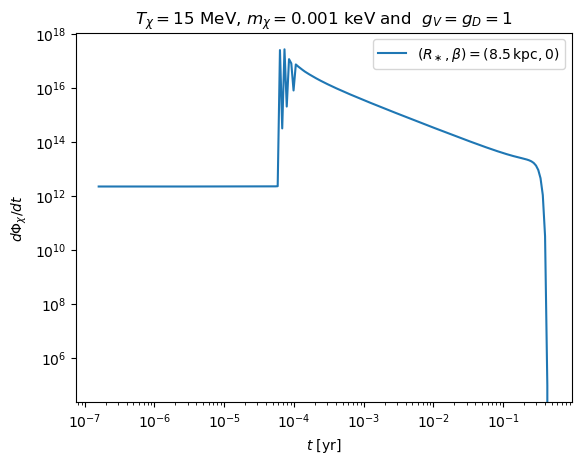

In [48]:
plt.plot(time_ls1/yr2s,bdmflux1 ,label=r'$(R_\ast,\beta)=(8.5\,{\rm kpc},0)$')
plt.plot(time_ls2/yr2s,bdmflux2 ,label=r'$(R_\ast,\beta)=(17\,{\rm kpc},0)$')
plt.plot(time_ls2/yr2s,bdmflux3 ,label=r'$(R_\ast,\beta)=(17\,{\rm kpc},\pi/2)$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$ [yr]')
plt.ylabel(r'$d\Phi_\chi/dt$')
plt.title(f'$T_\chi = {Tx}$ MeV, $m_\chi = {mx}$ keV and ' + ' $g_V=g_D=1$')
plt.legend()
#plt.ylim(1e-20)
#plt.savefig('flux_4.pdf',bbox_inches='tight')

## Event rate at different angle

In [18]:
# BDM kinematics
mx = 1
mV = mx
# Rstar
Rstar = 8.5
# Off-center angle
beta1 = 0
beta2 = 0.1 # in terms of pi
beta3 = 0.5
beta4 = 0.25
# Get the vanishing time and maximum theta_M
tvan,thetaM = get_tvan_thetaM(5,mx,Rstar)
# Truncate tvan at 35 years
if tvan > 35*yr2s: tvan = 35*yr2s
time_ls = np.logspace(np.log10(5),np.log10(tvan),200)

# setup function for ipyparallel
# the function is completely independent of this notebook
# everything required should be imported again within function body
def eventToF(phiBound,thetaBound,tvan,mx,mV,Rstar,beta,legacy=False):
    # import necessary package
    import vegas
    import numpy as np
    integ = vegas.Integrator([[10,tvan],[5,100],thetaBound,phiBound])
    if legacy is False:
        from supernovaNuBoostedDM import diffEventRateAtDetector
        # body
        try:
            result = integ(lambda x: diffEventRateAtDetector(x[0],x[1],mx,mV,Rstar,theta=x[2],phi=x[3],beta=beta),nitn=10,neval=2000).mean
            #exit_code = 0
        except:
            result = np.nan
            #exit_code = 1
    else:
        from bdmLegacy import diffFluxAtEarthLegacy
        try:
            result = integ(lambda x: diffFluxAtEarthLegacy(x[0],x[1],mx,Rstar,theta=x[2],phi=x[3],beta=beta,sigxv=1e-45),nitn=10,neval=2000).mean
        except:
            result = np.nan
    return result#,exit_code


In [3]:
# get phi bound
phiList = np.linspace(0,2*np.pi,181)
phiBound = []
for i in range(180):
    phiBound.append(phiList[i:i+2].tolist())
# get theta bound
#numTheta = int(np.ceil(thetaM*180/np.pi))
thetaList = np.linspace(0,0.5*np.pi,91)
thetaBound = []
for i in range(90):
    thetaBound.append(thetaList[i:i+2].tolist())

In [19]:
cpus = 6
legacy = True
bdmEvent = []
i=1
with ipp.Cluster(n = cpus) as rc:
    # get a view on the cluster
    view = rc.load_balanced_view()
    for theta_index in range(len(thetaBound)):
        # submit the tasks
        asyncresult = view.map_async(partial(eventToF,thetaBound=thetaBound[theta_index],tvan=tvan,mx=mx,mV=mV,Rstar=Rstar,beta=beta4*np.pi), phiBound)
        # wait interactively for results
        #asyncresult.wait_interactive()
        # retrieve actual results
        bdmEvent.append(asyncresult.get())
        print(f'{100*i/90:.3f}% completed!',end='\r')
        i+=1
np.save(f'../data/BDM_events/bdmEventAtAngle_mx{mx}_Rstar{Rstar}_beta{beta4}pi',bdmEvent)

Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

Stopping engine(s): 1678099422
engine set stopped 1678099422: {'engines': {'0': {'exit_code': 0, 'pid': 38898, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 38906, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 38907, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 38908, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 38909, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 38910, 'identifier': '5'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 38893, 'identifier': 'ipcontroller-1678099420-hvy6-36482'}


In [20]:
event1 = np.load(f'../data/BDM_events/bdmEventAtAngle_mx1_Rstar8.5_beta0pi.npy')
event2 = np.load(f'../data/BDM_events/bdmEventAtAngle_mx1_Rstar8.5_beta0.1pi.npy')
event3 = np.load(f'../data/BDM_events/bdmEventAtAngle_mx1_Rstar8.5_beta0.25pi.npy')
event4 = np.load(f'../data/BDM_events/bdmEventAtAngle_mx1_Rstar8.5_beta0.5pi.npy')

#event4 = np.load(f'../data/BDM_events/bdmLegacyEventAtAngle_mx1_Rstar8.5_beta0pi.npy')
#event5 = np.load(f'../data/BDM_events/bdmLegacyEventAtAngle_mx1_Rstar8.5_beta0.1pi.npy')
#event6 = np.load(f'../data/BDM_events/bdmLegacyEventAtAngle_mx1_Rstar8.5_beta0.5pi.npy')

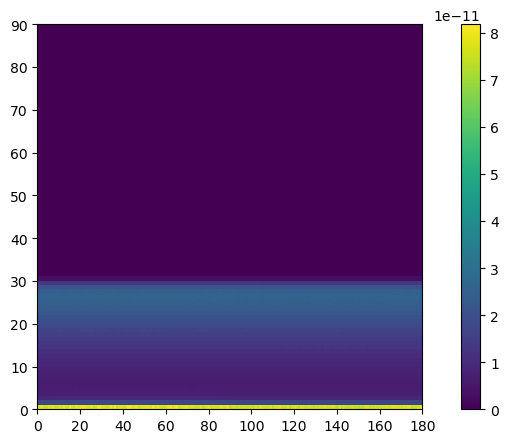

In [68]:
normpar = colors.LogNorm()
fig, _ = plt.subplots(figsize = (10,5))
smearplot = plt.imshow(event1, # plot the smearing values as an image, because python
                       # cmap = "CMRmap", # nice colormap
                       cmap = 'viridis',
                       interpolation = 'nearest', # avoid smoothing
                       origin = 'lower', # (0,0) is in the bottom left corner
                       extent = (0, 180, 0, 90), # set axis ranges
                       #norm = normpar, # log scale
                       aspect=2)
#plt.title('Smearing matrix', fontsize = 20)
#plt.xlabel('Neutrino energy (GeV)', fontsize = 20)
#plt.xticks( fontsize = 20 )
#plt.ylabel('Smeared reconstructed energy (GeV)', fontsize = 20)
#plt.yticks( fontsize = 20 )
plt.colorbar(smearplot)
#cbar = plt.colorbar(smearplot)
#cbar.ax.tick_params( labelsize = 20, length = 10, width = 2 )

plt.show()

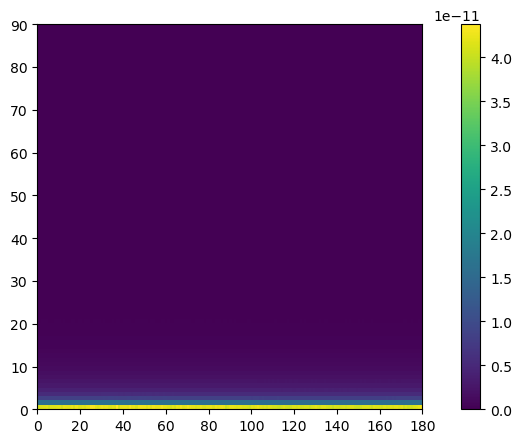

In [69]:
normpar = colors.LogNorm()
fig, _ = plt.subplots(figsize = (10,5))
smearplot = plt.imshow(event2, # plot the smearing values as an image, because python
                       # cmap = "CMRmap", # nice colormap
                       cmap = 'viridis',
                       interpolation = 'nearest', # avoid smoothing
                       origin = 'lower', # (0,0) is in the bottom left corner
                       extent = (0, 180, 0, 90), # set axis ranges
                       #norm = normpar, # log scale
                       aspect=2)
#plt.title('Smearing matrix', fontsize = 20)
#plt.xlabel('Neutrino energy (GeV)', fontsize = 20)
#plt.xticks( fontsize = 20 )
#plt.ylabel('Smeared reconstructed energy (GeV)', fontsize = 20)
#plt.yticks( fontsize = 20 )
plt.colorbar(smearplot)
#cbar = plt.colorbar(smearplot)
#cbar.ax.tick_params( labelsize = 20, length = 10, width = 2 )

plt.show()

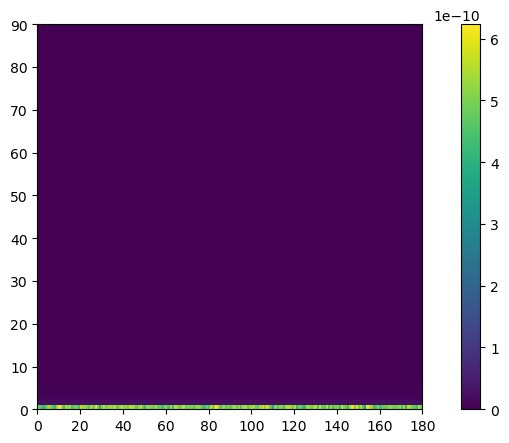

In [95]:
normpar = colors.LogNorm()
fig, _ = plt.subplots(figsize = (10,5))
smearplot = plt.imshow(event4, # plot the smearing values as an image, because python
                       # cmap = "CMRmap", # nice colormap
                       cmap = 'viridis',
                       interpolation = 'nearest', # avoid smoothing
                       origin = 'lower', # (0,0) is in the bottom left corner
                       extent = (0, 180, 0, 90), # set axis ranges
                       #norm = normpar, # log scale
                       aspect=2)
#plt.title('Smearing matrix', fontsize = 20)
#plt.xlabel('Neutrino energy (GeV)', fontsize = 20)
#plt.xticks( fontsize = 20 )
#plt.ylabel('Smeared reconstructed energy (GeV)', fontsize = 20)
#plt.yticks( fontsize = 20 )
plt.colorbar(smearplot)
#cbar = plt.colorbar(smearplot)
#cbar.ax.tick_params( labelsize = 20, length = 10, width = 2 )

plt.show()

(1e-14, 1e-09)

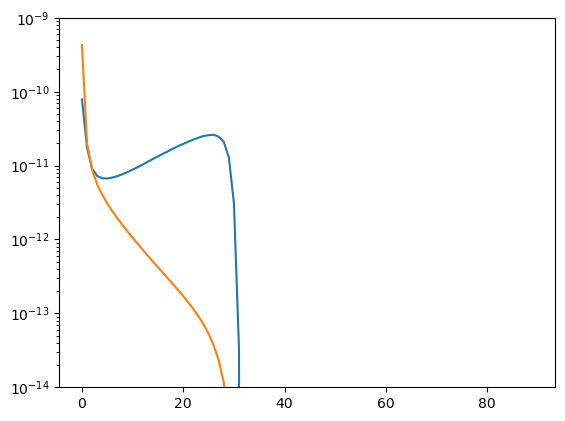

In [93]:
plt.plot(np.arange(90),event1[50])
plt.plot(np.arange(90),event4[50])
plt.yscale('log')
plt.ylim(1e-14,1e-9)

(0.07, 0.073)

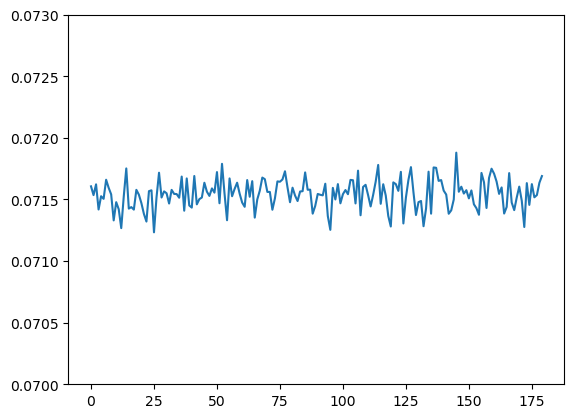

In [9]:
gV=1e-3
gD=1e-3
eps = gV
sigxv_fac = 1.05e10
sigxe = 1.05e-34
plt.plot(np.arange(180),event1[2]*7.473e33*gV**2*gD**4*eps**2)
plt.plot(np.arange(180),event3[2]*7.473e33*sigxv_fac*sigxe)
#plt.yscale('log')
plt.ylim(0.07,0.073)

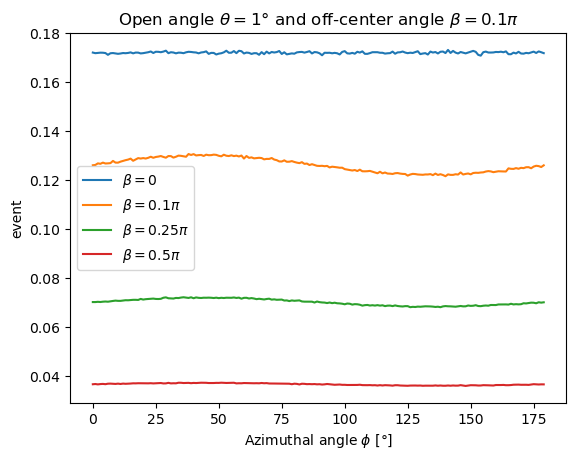

In [32]:
plt.plot(np.arange(180),event1[1]*7.473e33*gV**2*gD**4*eps**2,label=r'$\beta=0$')
plt.plot(np.arange(180),event2[1]*7.473e33*gV**2*gD**4*eps**2,label=r'$\beta=0.1\pi$')
plt.plot(np.arange(180),event3[1]*7.473e33*gV**2*gD**4*eps**2,label=r'$\beta=0.25\pi$')
plt.plot(np.arange(180),event4[1]*7.473e33*gV**2*gD**4*eps**2,label=r'$\beta=0.5\pi$')
plt.legend()
#plt.yscale('log')
#plt.ylim(0.01,0.075)
plt.xlabel(r'Azimuthal angle $\phi~[\degree]$')
plt.title(r'Open angle $\theta = 1\degree$ and off-center angle $\beta=0.1\pi$')
plt.ylabel('event')
plt.savefig('../plots/event_betas.pdf',bbox_inches='tight')

In [94]:
500*22*35

385000

In [89]:
#theta_ls = np.logspace(-5,np.log10(np.pi/2),50)
#phi_ls = np.linspace(0,2*np.pi,20)
gV = 1e-6
gD = 1e-6
event_Rstar1 = []
event_Rstar2 = []
mx_ls = np.logspace(-6,1.5,20)
Rstar1= 8.5
Rstar2= 17
i = 1
for mx in mx_ls:
    mV = mx/3
    # Target function
    def f1(x):
        t = x[0]
        Tx = x[1]
        theta = x[2]
        phi = x[3]
        return diffFluxAtEarth(t,Tx,mx,mV,Rstar1,theta=theta,phi=phi,beta=0,gV=gV,gD=gD)
    
    def f2(x):
        t = x[0]
        Tx = x[1]
        theta = x[2]
        phi = x[3]
        return diffFluxAtEarth(t,Tx,mx,mV,Rstar2,theta=theta,phi=phi,beta=0.5*np.pi,gV=gV,gD=gD)
    # Setup integrand for vegas
    tvan1,thetaM1 = get_tvan_thetaM(5,mx,Rstar1)
    tvan2,thetaM2 = get_tvan_thetaM(5,mx,Rstar2)
    if tvan1 > 35*yr2s: tvan1 = 35*yr2s
    else: pass
    if tvan2 > 35*yr2s: tvan2 = 35*yr2s
    else: pass
    integ1 = vegas.Integrator([[1,tvan1],[5,100],[0, thetaM1],[0,2*np.pi]])
    integ2 = vegas.Integrator([[1,tvan2],[5,100],[0, thetaM2],[0,2*np.pi]])
    result1 = integ1(f1,nitn=10,neval=10000)
    event_Rstar1.append(result1.mean)
    result2 = integ2(f2,nitn=10,neval=10000)
    event_Rstar2.append(result2.mean)
    
    print(i,end='\r')
    i+=1

Text(0, 0.5, '$\\int \\frac{d\\Phi_\\chi}{dT_\\chi dt} dT_\\chi dt$')

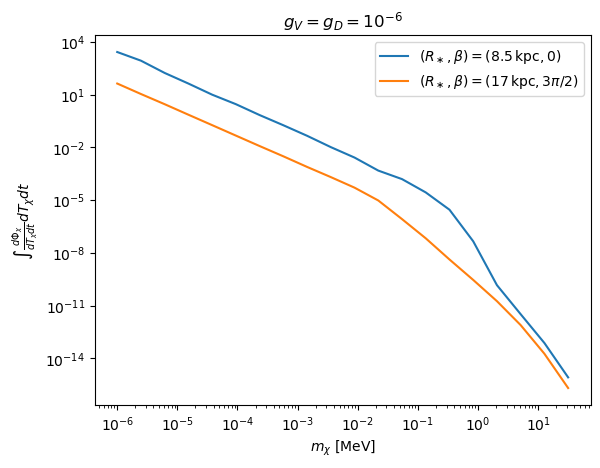

In [90]:
plt.plot(mx_ls,np.array(event_Rstar1),label=r'$(R_\ast,\beta)=(8.5\,{\rm kpc},0)$')
#plt.plot(mx_ls,event_theta001,label=r'$\beta=0.001$')
plt.plot(mx_ls,event_Rstar2,label=r'$(R_\ast,\beta)=(17\,{\rm kpc},3\pi/2)$')
#plt.plot(mx_ls,event_t_bound,'.',label=r'$t_{\rm interval}=[5\,{\rm s},35\,{\rm yrs}]$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$g_V=g_D=10^{-6}$')
plt.legend()
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$\int \frac{d\Phi_\chi}{dT_\chi dt} dT_\chi dt$')
#plt.savefig('event.pdf',bbox_inches='tight')
#plt.ylim(1e-4,1e1)

In [3]:
#Tx = 15
mx = 1e-3
Rstar = 8.5
beta = 0.1
mV = mx
tvan,_ = get_tvan_thetaM(Tx,mx,Rstar)

In [5]:
integ = vegas.Integrator([[10,tvan],[5,100],[0,np.pi/2],[0,2*np.pi]])


In [6]:
def _f(x):
    t = x[0]
    Tx = x[1]
    theta = x[2]
    phi = x[3]
    return diffEventRateAtDetector(t,Tx,mx,mV,Rstar,theta,phi,beta)

In [8]:
integ(_f,nitn=10,neval=2000).mean

233.60818883868015

In [22]:
95/5

19.0

In [25]:
from functools import partial

In [48]:
def test(a,b,c,d):
    return a,b,c,d

In [49]:
test(1,2,3,4)

(1, 2, 3, 4)

In [55]:
testP=partial(test,c=3,b=2)

In [56]:
testP(1,d=4)


(1, 2, 3, 4)

In [66]:
np.load('1.0.npy',allow_pickle=True).ndim

1

In [69]:
np.array([[1],[3]]).ndim

2

In [61]:
np.concatenate(([1.,2],[19,59,33,1]))

array([ 1.,  2., 19., 59., 33.,  1.])

In [73]:
np.vstack(([7,8,9,10],np.array([[1,0],[2,0],[3,0],[4,0]]).T))

array([[ 7,  8,  9, 10],
       [ 1,  2,  3,  4],
       [ 0,  0,  0,  0]])

In [90]:
f'{7{6}0:d}'

SyntaxError: f-string: invalid syntax (2144201710.py, line 1)